In [1]:
import numpy as np 
import pandas as pd
import os
import sys
import email
import re
import matplotlib.pyplot as plt
%matplotlib inline
import hashlib

In [2]:
os.getcwd()

'/Users/spielman/rep/class/262'

In [3]:
# reading from files ahead of time so won't loose time in class
few_emails = pd.read_pickle("data/enron/enron1k.pkl")
df = pd.read_pickle("data/enron/enronEmails.pkl")
df.reset_index(inplace=True)
hashes = np.load("data/enron/enronHash.npy")

In [4]:
df = df.head(100000)
hashes = hashes[0:100000,:]
print df.shape
print hashes.shape

(100000, 19)
(100000, 100)


In [5]:
# code from last lecture

f = open('stopwords.txt')
lines = f.readlines()
f.close()

stop_list = []
for l in lines:
    stop_list.append(l.strip())

def make_bag(string):
    letters_only = re.sub("[^a-zA-Z]",           # The pattern to search for
                      " ",                   # The pattern to replace it with
                      string )  # The text to search
    lower_case = letters_only.lower()        # Convert to lower case
    words = lower_case.split()               # Split into words
    sorted_words = sorted(set(words))
    bag = [w for w in sorted_words if not w in stop_list]
    return bag

def jaccard(a,b):
    len_sum = len(a) + len(b)
    len_union = len(set(a).union(set(b)))
    len_inter = len_sum - len_union
    return (len_inter + 0.0) / len_union


def jaccard_emails(i,j):
    return jaccard(make_bag(df.content[i]), make_bag(df.content[j]))

def hash_word(hashnum, word):
    hash_object = hashlib.md5(str(hashnum) + word)
    hex_hash = hash_object.hexdigest()
    return int(hex_hash[0:8],16)

def min_hash(hashnum,bag):

    return min([hash_word(hashnum,w) for w in bag])

In [6]:
start here

SyntaxError: invalid syntax (<ipython-input-6-15b48c174146>, line 1)

In [7]:
def prob_gr(s,g,r):
    return 1-(1-s**g)**r

g = 3
r = 5
print prob_gr(0.9,g,r), prob_gr(0.1,g,r)

0.99853833969 0.004990009995


0.9 0.99544186551
0.5 0.0212757912072


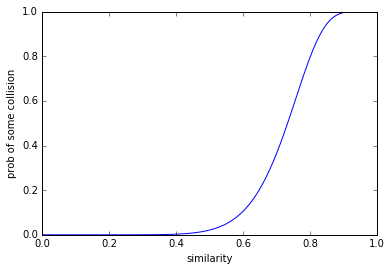

In [12]:
g = 9
r = 11
ss = np.arange(0,1,.01)
pr = [prob_gr(s,g,r) for s in ss]
print 0.9, prob_gr(0.9,g,r)
print 0.5, prob_gr(0.5,g,r)
plt.plot(ss,pr)
plt.xlabel('similarity')
plt.ylabel('prob of some collision')

In [13]:
def group_hashes(hs, g, r):
    return [tuple(hs[(i*g):((i+1)*g)]) for i in range(r)]
group_hashes(np.arange(0,15),3,5)

[(0, 1, 2), (3, 4, 5), (6, 7, 8), (9, 10, 11), (12, 13, 14)]

In [14]:
def empty_lsh_table(r):
    return [{} for i in range(r)]
lshT = empty_lsh_table(r)
lshT

[{}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}]

In [15]:
def add_hash(ht, h, i):
    if h in ht:
        ht[h].append(i)
    else:
        ht[h] = [i]
        

In [16]:
x = np.random.randint(5, size=10)
x

array([2, 3, 0, 0, 3, 0, 4, 4, 4, 3])

In [17]:
ht = {}
for i in range(10):
    add_hash(ht, x[i], i)
ht

{0: [2, 3, 5], 2: [0], 3: [1, 4, 9], 4: [6, 7, 8]}

In [18]:
def add_hashes(lshT, hs, i, g, r):
    group = group_hashes(hs, g, r)
    for j in range(r):
        add_hash(lshT[j], group[j], i)
        


In [19]:
lshT = empty_lsh_table(r)
for i in range(len(df)):
    add_hashes(lshT, hashes[i], i, g, r)


In [20]:
def lsh_lookup(lshT, i, g, r):
    group = group_hashes(hashes[i], g, r)
    s = set()
    for j in range(r):
        print set(lshT[j][group[j]])
        s = s.union(set(lshT[j][group[j]]))
    return s


In [24]:
i = 101
s = lsh_lookup(lshT, i, g, r)
s

set([88449, 101, 2502, 90280, 89356, 689, 90324, 1589, 89307, 91132])
set([88449, 88355, 101, 2502, 90280, 89356, 89260, 689, 1589, 91132, 91037, 90367])
set([88449, 101, 2502, 90280, 89356, 689, 1589, 91132])
set([101, 2502, 689, 90324, 1589, 89307])
set([88449, 101, 2502, 90280, 89356, 689, 1589, 91132])
set([88449, 101, 2502, 90280, 89356, 689, 90324, 1589, 89307, 91132])
set([88449, 101, 2502, 90280, 89356, 689, 90324, 1589, 89307, 91132])
set([88449, 101, 2502, 90280, 89356, 689, 90324, 1589, 89307, 91132])
set([88449, 88355, 101, 2502, 90280, 89356, 89260, 689, 1589, 91132, 91037, 90367])
set([689, 101, 2502, 1589])
set([88355, 101, 2502, 89260, 689, 1589, 91037, 90367])


{101,
 689,
 1589,
 2502,
 88355,
 88449,
 89260,
 89307,
 89356,
 90280,
 90324,
 90367,
 91037,
 91132}

In [25]:
for j in s:
    print jaccard(make_bag(df.content[i]), make_bag(df.content[j]))

0.967741935484
1.0
0.967741935484
0.89552238806
0.89552238806
0.899224806202
0.899224806202
1.0
0.967741935484
0.899224806202
1.0
1.0
0.967741935484
0.899224806202


In [26]:
print df.content[i]

---------------------- Forwarded by Phillip K Allen/HOU/ECT on 08/16/2000 
10:58 AM ---------------------------
   
	
	
	From:  David W Delainey                           08/15/2000 01:28 PM
	

Sent by: Kay Chapman
To: Tim Belden/HOU/ECT@ECT, Kevin M Presto/HOU/ECT@ECT, John 
Arnold/HOU/ECT@ECT, Scott Neal/HOU/ECT@ECT, Hunter S Shively/HOU/ECT@ECT, 
Phillip K Allen/HOU/ECT@ECT, Janet R Dietrich/HOU/ECT@ECT, Christopher F 
Calger/PDX/ECT@ECT, W David Duran/HOU/ECT@ECT, Raymond Bowen/HOU/ECT@ECT, 
Jeff Donahue/HOU/ECT@ECT, Brian Redmond/HOU/ECT@ECT, C John 
Thompson/Corp/Enron@ENRON, Scott Josey/Corp/Enron@ENRON, Rob 
Milnthorp/CAL/ECT@ECT, Max Yzaguirre/NA/Enron@ENRON, Beth 
Perlman/HOU/ECT@ECT, Wes Colwell/HOU/ECT@ECT, Sally Beck/HOU/ECT@ECT, David 
Oxley/HOU/ECT@ECT, Joseph Deffner/HOU/ECT@ECT, Jordan Mintz/HOU/ECT@ECT, Mark 
E Haedicke/HOU/ECT@ECT
cc: Mollie Gustafson/PDX/ECT@ECT, Felicia Doan/HOU/ECT@ECT, Ina 
Rangel/HOU/ECT@ECT, Kimberly Brown/HOU/ECT@ECT, Airam Arteaga/HOU/ECT@ECT

In [27]:
s = sorted(list(s))
print df.content[s[-1]]


This is it.  So sorry I left you name off.

Kay


   
	
	
	From:  David W Delainey                           08/15/2000 03:28 PM
	

Sent by: Kay Chapman
To: Tim Belden/HOU/ECT@ECT, Kevin M Presto/HOU/ECT@ECT, John 
Arnold/HOU/ECT@ECT, Scott Neal/HOU/ECT@ECT, Hunter S Shively/HOU/ECT@ECT, 
Phillip K Allen/HOU/ECT@ECT, Janet R Dietrich/HOU/ECT@ECT, Christopher F 
Calger/PDX/ECT@ECT, W David Duran/HOU/ECT@ECT, Raymond Bowen/HOU/ECT@ECT, 
Jeff Donahue/HOU/ECT@ECT, Brian Redmond/HOU/ECT@ECT, C John 
Thompson/Corp/Enron@ENRON, Scott Josey/Corp/Enron@ENRON, Rob 
Milnthorp/CAL/ECT@ECT, Max Yzaguirre/NA/Enron@ENRON, Beth 
Perlman/HOU/ECT@ECT, Wes Colwell/HOU/ECT@ECT, Sally Beck/HOU/ECT@ECT, David 
Oxley/HOU/ECT@ECT, Joseph Deffner/HOU/ECT@ECT, Jordan Mintz/HOU/ECT@ECT, Mark 
E Haedicke/HOU/ECT@ECT
cc: Mollie Gustafson/PDX/ECT@ECT, Felicia Doan/HOU/ECT@ECT, Ina 
Rangel/HOU/ECT@ECT, Kimberly Brown/HOU/ECT@ECT, Airam Arteaga/HOU/ECT@ECT, 
Christy Chapman/HOU/ECT@ECT, Tina Rode/HOU/ECT@ECT, Marsha 

mean :  2.1245405681
median :  2.0
max :  262
sum squares :  516090


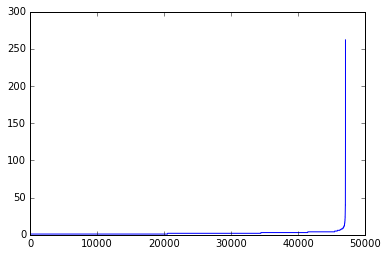

In [28]:
sz = [len(v) for v in lshT[0].values()]
print 'mean : ', np.mean(sz)
print 'median : ', np.median(sz)
print 'max : ', max(sz)
print 'sum squares : ', sum(np.array(sz)**2)
plt.plot(sorted(sz))

In [29]:
ss = 0
for j in range(r):
    sz = [len(v) for v in lshT[j].values()]
    ss += sum(np.array(sz)**2)
ss

5596988